# Nudge Text Embeddings

In this notebook we see what happens to the output of Stable Diffusion as we nudge the (initially _"unconditional"_) text embeddings (_"context"_).

In [ ]:
import math

import tensorflow as tf
import matplotlib.pyplot as plt

from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
from diffusion_models.stable_diffusion import StableDiffusion
from utils import process_image, augmenter

In [ ]:
print(f"GPUs available: ", tf.config.experimental.list_physical_devices('GPU'))
device = tf.test.gpu_device_name()
print(tf.test.gpu_device_name())

# Initialize SD Model

In [ ]:
# Inialize Stable Diffusion Model on GPU:0
with tf.device(device):
    image_encoder = ImageEncoder()
    vae = tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-1].output,
    )
    model = StableDiffusion(img_width=512, img_height=512)

# Run image through VAE encoder

In [4]:
image_path = "images/sa_224452.jpg"

with tf.device(device):
    image = process_image(image_path)
    image = augmenter(image)
    latent = vae(tf.expand_dims(image, axis=0), training=False)

# Perform Stable Diffusion inference

We perform inference and and try out different `context` variants to condition the model, including the default `unconditional_context` (achieved by passing `context = None`).

In [5]:
timestep = 300

# Context is an embedding of shape (1, 77, 768)
contexts = [
    ("Unconditional",     None),                                             
    ("N(0, 1)",           tf.random.normal(shape=(1, 77, 768))),
    ("Constant: -30",     tf.fill(dims=(1, 77, 768), value=-3.)),
    ("Constant: 0",       tf.zeros(shape=(1, 77, 768))),           
    ("Constant: 30",      tf.fill(dims=(1, 77, 768), value=3.)),
    ("Uniform(-1, 1)]",   tf.random.uniform(shape=(1, 77, 768), minval=-1,   maxval=1)),
    ("Uniform(-10, 10)]", tf.random.uniform(shape=(1, 77, 768), minval=-10,  maxval=10)),
    ("Uniform(-30, 30)]", tf.random.uniform(shape=(1, 77, 768), minval=-30,  maxval=30)),
    ("Uniform(-50, 50)]", tf.random.uniform(shape=(1, 77, 768), minval=-50,  maxval=50))
]

# Collect output images of shape (512, 512, 3)
outputs = []

for _, context in contexts:
    with tf.device(device):
        # Stable Diffusion inference for a single timestep
        output_image, weight_64, weight_32, weight_16, weight_8 = model.generate_image(
            batch_size=1,
            latent=latent,
            timestep=timestep,
            context=context
        )
        outputs.append(output_image.squeeze())

2023-12-10 16:07:36.391666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


unconditional context min:  -28.09122
unconditional context max:  33.063164


# Visualise the SD outputs for the different context embeddings

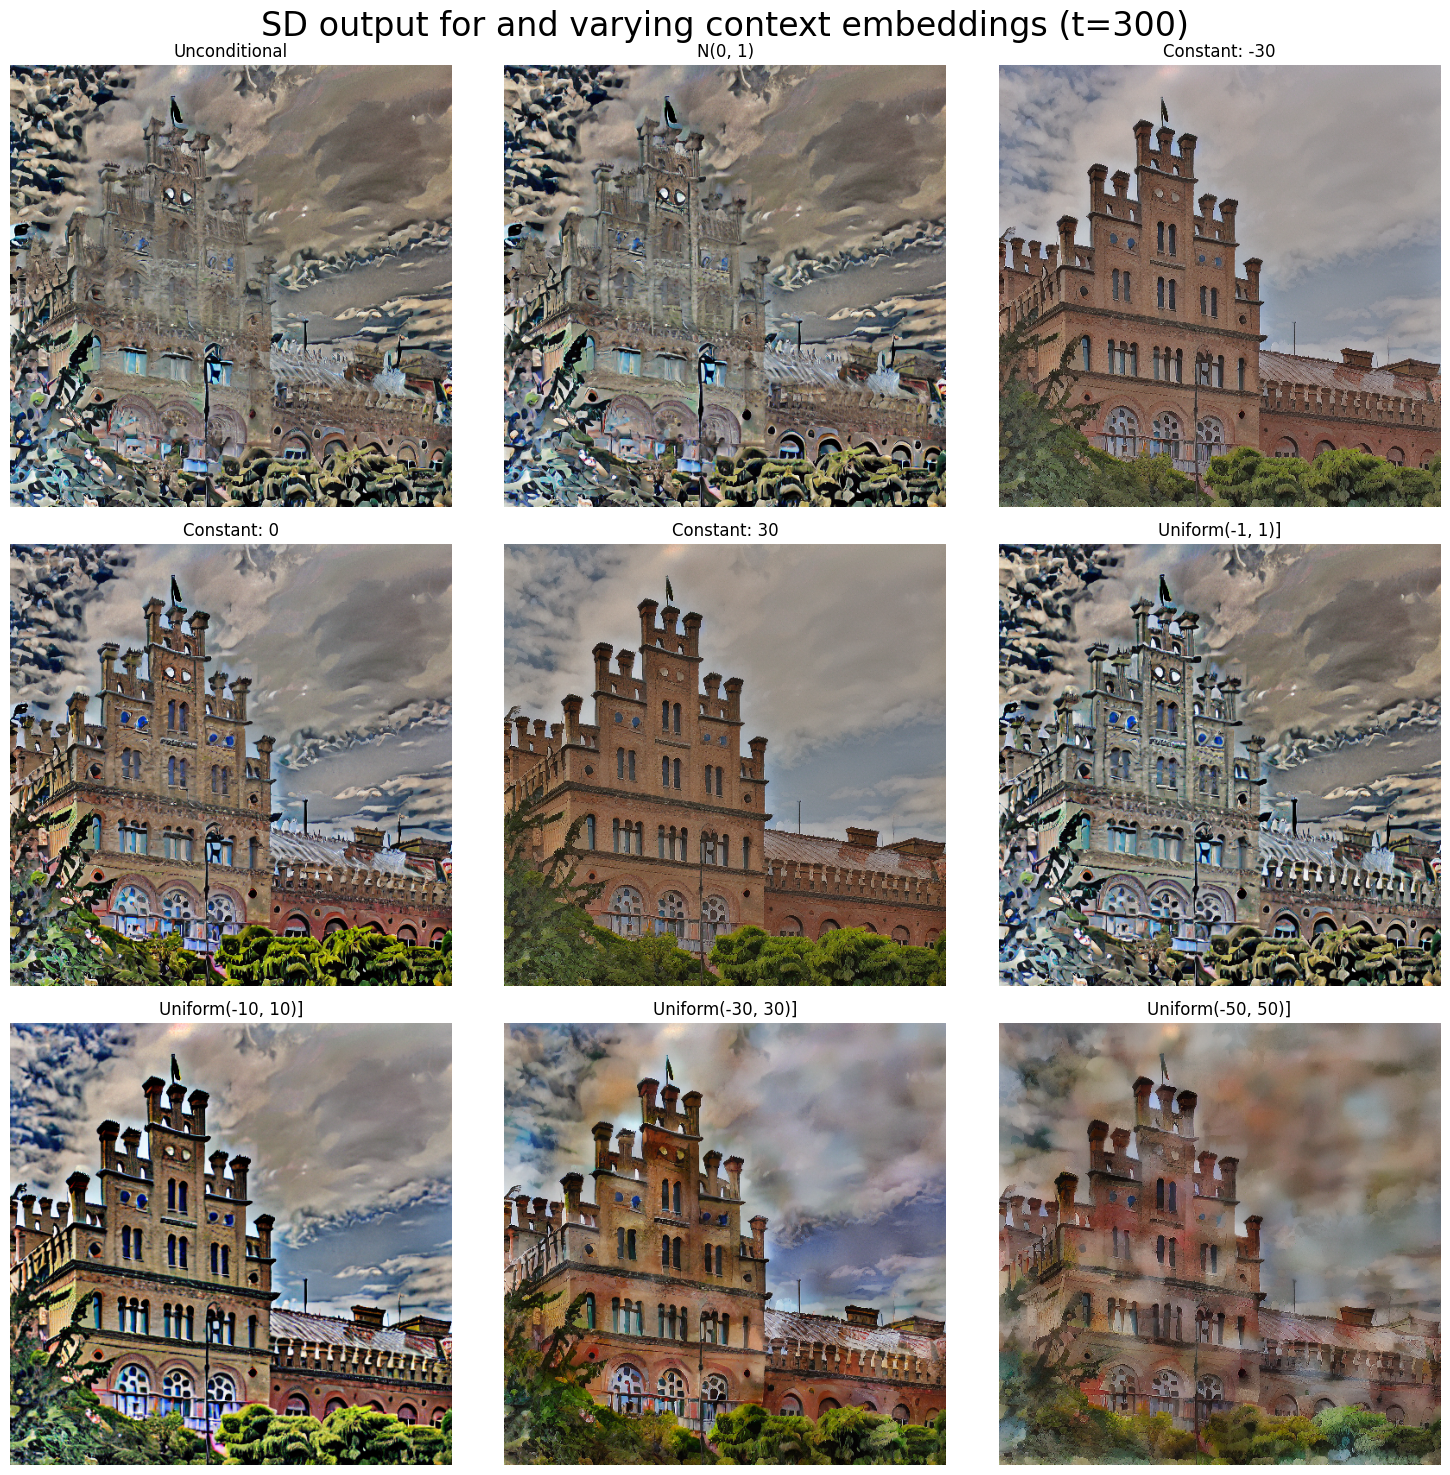

In [6]:
# Calculate the number of rows and columns for the grid
num_outputs = len(outputs)
num_cols = math.ceil(math.sqrt(num_outputs))
num_rows = math.ceil(num_outputs / num_cols)

# Create the subplots grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axs array if it is not already flattened
if axs.ndim > 1:
    axs = axs.flatten()

# Iterate over the outputs and plot them in the grid
for i, output in enumerate(outputs):
    axs[i].imshow(output)
    axs[i].set_title(contexts[i][0])
    axs[i].axis('off')

# Remove empty subplots
for j in range(num_outputs, len(axs)):
    axs[j].axis('off')

fig.suptitle(f"SD output for and varying context embeddings (t={timestep})", fontsize=24)
fig.tight_layout()
plt.show()